In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import sys
import random
from glob import glob

from multiprocessing import Pool
import numpy as np
import pandas as pd

from tqdm import tqdm
import scipy.misc
from skimage.morphology import label
import skimage

import warnings
warnings.filterwarnings('ignore')

In [3]:
sys.path.append('../models/Mask_RCNN')

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


Using TensorFlow backend.


# Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, load_shapes(), and override the following methods:

    load_image()
    load_mask()
    image_reference()

In [5]:
# Set some parameters
IMG_CHANNELS = 3
DATA = {
    'TRAIN': '/home/wellbeier/cdata/kaggle-dsbowl-2018-dataset-fixes/stage1_train/',
    'TEST': '/home/wellbeier/cdata/test/',
    'AUGMENTED': '/home/wellbeier/cdata/augmented/',
    'PREPARED': '/home/wellbeier/cdata/prepared/'
}

paths = glob(os.path.join(DATA['TRAIN'], '*'))
test_paths = [os.path.basename(path) for path in glob(os.path.join(DATA['TEST'], '*'))]

MASK_POSTFIX = 'mask_rcnn'
seed = 42
P_THRESHOLD = .5
BATCH_SIZE = 1
SIDE = 256
STEP = SIDE // 4

# Amount of categories predicted per pixels.
nb_classes = 1

SPLIT = .9

In [6]:
class NucleiDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_nuclei(self, paths, probs=None):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("nucleis", 1, "nuclei")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i, path in tqdm(enumerate(paths)):
            im = np.load(path)
            self.add_image("nucleis", image_id=i, path=path,
                           width=im.shape[1], height=im.shape[0])

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]

        im = np.load(info['path']).astype(np.float32)
        im = (im - im.min((0, 1))) / (im.max((0, 1)) - im.min((0, 1)))
        return im

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        return info["path"]

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        mask = np.load(os.path.join(info['path'][:-4] + 'mask.npy'))

        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index("nuclei") for s in range(mask.shape[-1])])
        return mask.astype(np.uint8), class_ids.astype(np.int32)

In [11]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nucleis"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = BATCH_SIZE
    USE_MINI_MASK = False
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 640
    DETECTION_MAX_INSTANCES = 300
    MAX_GT_INSTANCES = 300
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]
    USE_MINI_MASK = False
    
#     IMAGE_SHAPE = (128, 128, 1)

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = len(train_paths) // BATCH_SIZE + 1

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = len(valid_paths) // BATCH_SIZE + 1
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[160 160]
 [ 80  80]
 [ 40  40]
 [ 20  20]
 [ 10  10]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  640
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               300
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nucleis
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING       

In [12]:
from collections import defaultdict
import pickle

image_types = pickle.load(open('/home/wellbeier/cdata/meta/image_types.pkl', 'rb'))
mask_types = pickle.load(open('/home/wellbeier/cdata/meta/mask_types.pkl', 'rb'))

types = np.unique(list(image_types.values()))
type_dict = defaultdict(list)
for pid, type_id in image_types.items():
    type_dict[type_id].append(pid)

ids = [os.path.basename(path) for path in paths]

for key in type_dict.keys():
    type_dict[key] = [pid for pid in type_dict[key] if pid in ids]
    
train_paths = list()
valid_paths = list()    
for key in type_dict.keys():
    rs = np.random.RandomState(seed=12)
    rs.shuffle(type_dict[key])
    train_paths.extend(type_dict[key][len(type_dict[key]) - int(SPLIT * len(type_dict[key])):])
    valid_paths.extend(type_dict[key][:len(type_dict[key]) - int(SPLIT * len(type_dict[key]))])

In [13]:
def build_full(ids, root_dirs):
    paths = list()
    for root_dir in root_dirs:
        for pid in ids:
            paths.extend(glob(os.path.join(root_dir, '*', pid + '*[0-9].npy')))
    return paths

In [14]:
train_paths = build_full(train_paths, [DATA['PREPARED'], os.path.join(DATA['AUGMENTED'], 'E1')])
rs = np.random.RandomState(seed=12)
rs.shuffle(train_paths)

valid_paths = build_full(valid_paths, [DATA['PREPARED']])

In [15]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(paths=train_paths)
dataset_train.prepare()


# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(paths=valid_paths)
dataset_val.prepare()


# Test dataset
# dataset_test = NucleiDataset()
# dataset_test.load_nuclei(paths=test_paths)
# dataset_test.prepare()

1664it [00:01, 1133.39it/s]
69it [00:00, 1645.91it/s]


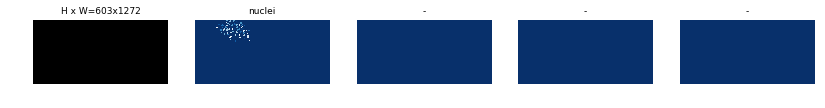

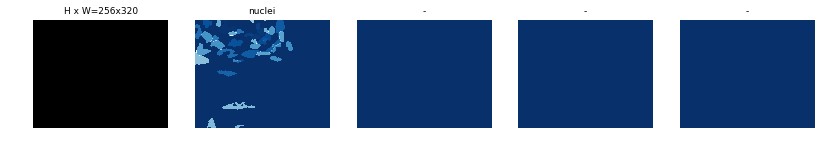

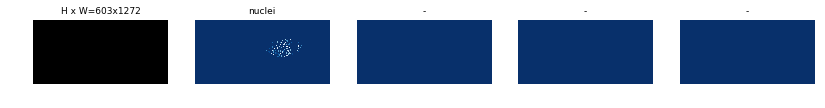

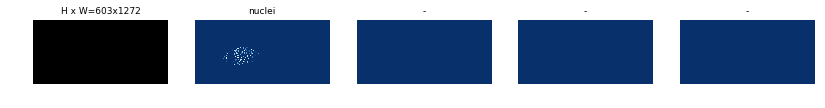

In [16]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Ceate Model

In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

mask_rcnn_nucleis_0007.h5 with pool 20 & mask_shape = [40, 40]

In [18]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
    
# model.load_weights('mask_rcnn_nucleis_0007.h5', by_name=True)

# Training

Train in two stages:

    Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

    Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [19]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/wellbeier/Projects/DSB18/IPython/logs/nucleis20180301T2209/mask_rcnn_nucleis_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

KeyboardInterrupt: 

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")


Starting at epoch 10. LR=0.0001

Checkpoint Path: /home/race/cdata/DSB18/IPython/logs/nucleis20180220T0524/mask_rcnn_nucleis_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



604/604 [==============================] - 670s 1s/step - loss: 1.2516 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 0.4331 - mrcnn_class_loss: 0.1953 - mrcnn_bbox_loss: 0.2287 - mrcnn_mask_loss: 0.3295 - val_loss: 0.9384 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.4786 - val_mrcnn_class_loss: 0.0667 - val_mrcnn_bbox_loss: 0.1557 - val_mrcnn_mask_loss: 0.2354
Epoch 27/100
604/604 [==============================] - 664s 1s/step - loss: 1.2431 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.4268 - mrcnn_class_loss: 0.1956 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.3306 - val_loss: 0.8305 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.4501 - val_mrcnn_class_loss: 0.0372 - val_mrcnn_bbox_loss: 0.1379 - val_mrcnn_mask_loss: 0.2041
Epoch 28/100
604/604 [==============================] - 657s 1s/step - loss: 1.2163 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 0.4195 - mrcnn_class_loss: 0.1920 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3246 - val_loss: 0.8840 - val_rpn_class_loss: 0.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



604/604 [==============================] - 653s 1s/step - loss: 1.1394 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.3803 - mrcnn_class_loss: 0.1869 - mrcnn_bbox_loss: 0.2127 - mrcnn_mask_loss: 0.3096 - val_loss: 0.8672 - val_rpn_class_loss: 0.0028 - val_rpn_bbox_loss: 0.4506 - val_mrcnn_class_loss: 0.0546 - val_mrcnn_bbox_loss: 0.1452 - val_mrcnn_mask_loss: 0.2140
Epoch 42/100
604/604 [==============================] - 665s 1s/step - loss: 1.1386 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.3809 - mrcnn_class_loss: 0.1867 - mrcnn_bbox_loss: 0.2100 - mrcnn_mask_loss: 0.3112 - val_loss: 0.8377 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.4762 - val_mrcnn_class_loss: 0.0310 - val_mrcnn_bbox_loss: 0.1180 - val_mrcnn_mask_loss: 0.2100
Epoch 43/100
604/604 [==============================] - 679s 1s/step - loss: 1.1292 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.3733 - mrcnn_class_loss: 0.1838 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.3110 - val_loss: 0.8861 - val_rpn_class_loss: 0.

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "__mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

In [12]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.keras_model.load_weights('logs/nucleis20180220T0524/mask_rcnn_nucleis_0044.h5', by_name=True)

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: res4v_branch2b_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=4088231, _device="/job:localhost/replica:0/task:0/device:GPU:0"](res4a_branch2b/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'res4v_branch2b_1/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-1e5767c3ef6a>", line 2, in <module>
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
  File "../models/Mask_RCNN/model.py", line 1841, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "../models/Mask_RCNN/model.py", line 1897, in build
    C1, C2, C3, C4, C5 = resnet_graph(input_image, "resnet101", stage5=True)
  File "../models/Mask_RCNN/model.py", line 169, in resnet_graph
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i))
  File "../models/Mask_RCNN/model.py", line 96, in identity_block
    name=conv_name_base + '2b', use_bias=use_bias)(x)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/keras/engine/topology.py", line 590, in __call__
    self.build(input_shapes[0])
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/keras/layers/convolutional.py", line 138, in build
    constraint=self.kernel_constraint)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/keras/engine/topology.py", line 411, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/keras/initializers.py", line 217, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3829, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/ops/random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/ops/gen_random_ops.py", line 449, in _random_uniform
    name=name)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: res4v_branch2b_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=4088231, _device="/job:localhost/replica:0/task:0/device:GPU:0"](res4a_branch2b/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


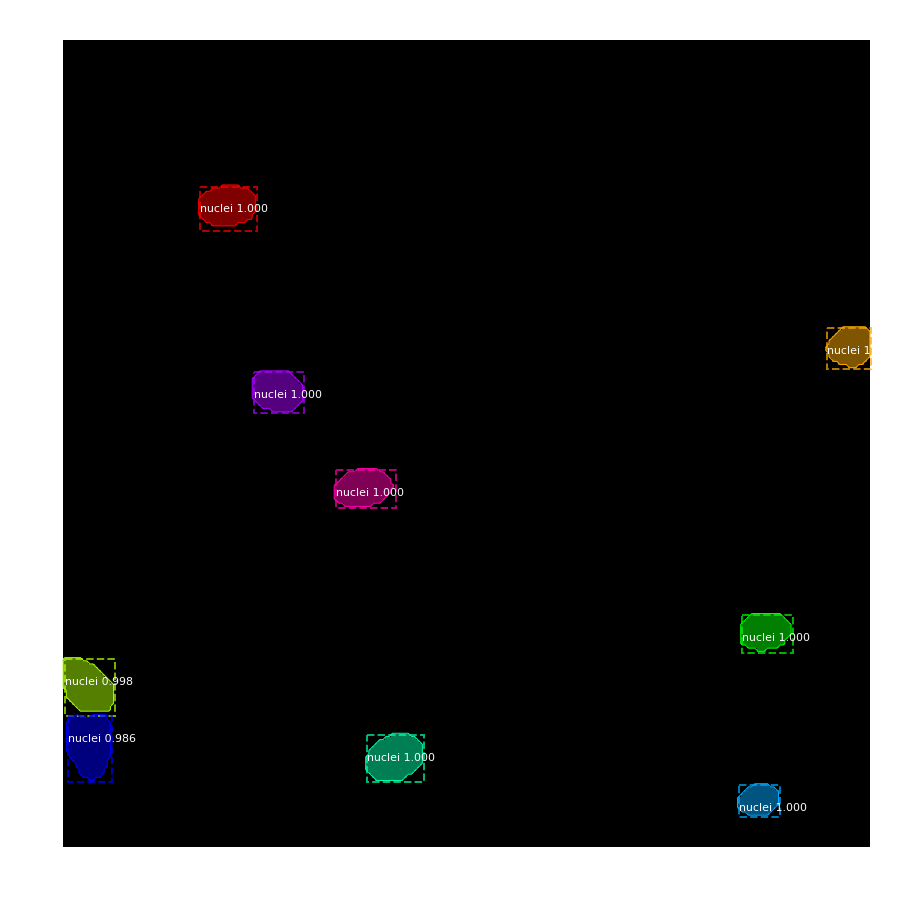

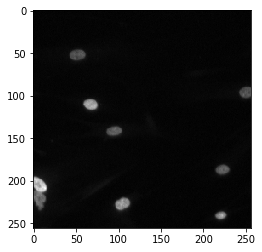

In [29]:
image_ids = np.random.choice(dataset_val.image_ids, 1)
image = dataset_val.load_image(image_ids[0])
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', 'nuclei'], r['scores'])
plt.imshow(image)

Processing 1 images
image                    shape: (520, 696, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  860.00000


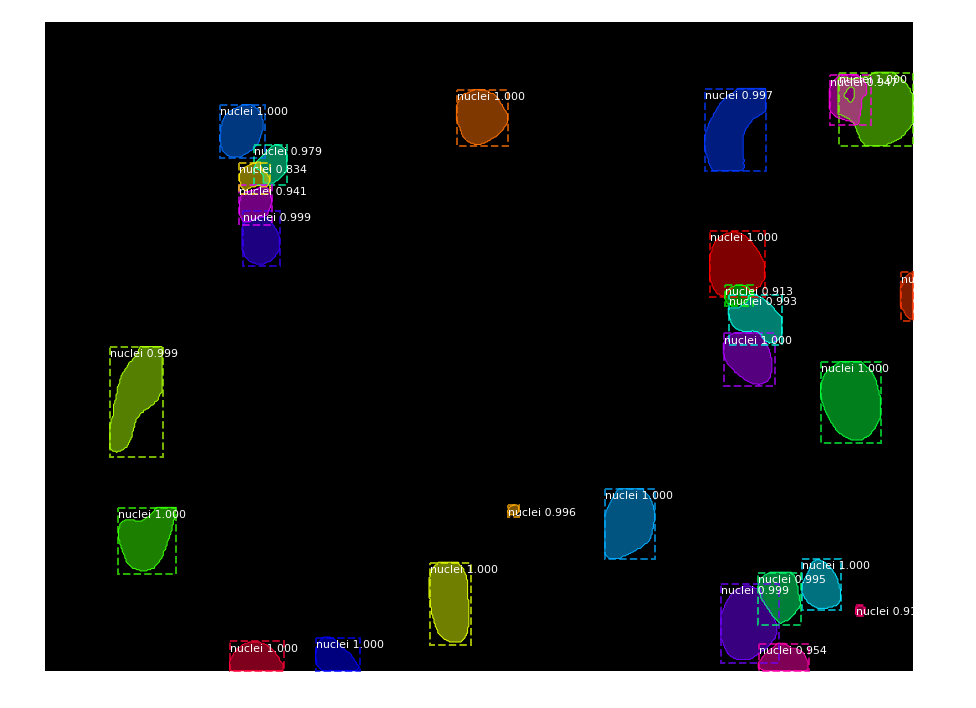

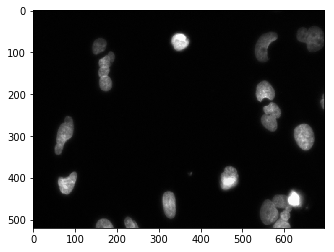

In [31]:
image_ids = np.random.choice(dataset_test.image_ids, 1)
image = dataset_test.load_image(image_ids[0])
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', 'nuclei'], r['scores'])
plt.imshow(image)

In [20]:
images = [dataset_test.load_image(image_ids) for image_ids in dataset_test.image_ids]
# Run detection
results = [model.detect([image], verbose=1) for image in images]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (519, 253, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  774.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000
Processing 1 images
image                    shape: (519, 162, 3)         min:    0.00000  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)

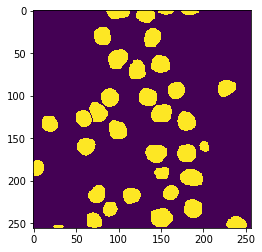

In [99]:
plt.imshow(np.max(r['masks'], -1))

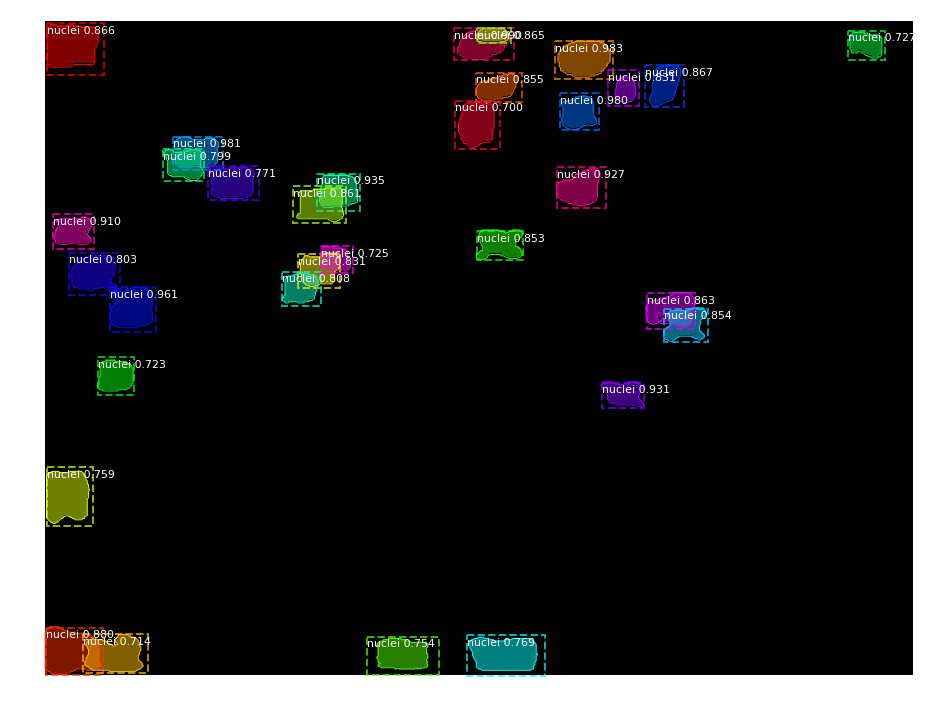

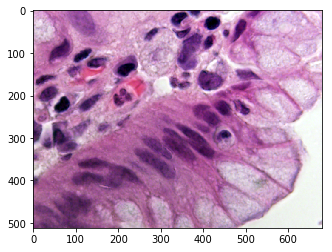

In [25]:
i = 27
# Visualize results
r = results[i][0]
visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], 
                            ['BG', 'nuclei'], r['scores'])
plt.imshow(images[i])

In [44]:
sys.path.append('../models/Mask_RCNN')

from config import Config
import utils
import model as modellib
import visualize
from model import log

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
i = 2
plt.imshow(a[0][i,...,0])
plt.show()
plt.imshow(a[1][i,...,0])

NameError: name 'a' is not defined

In [105]:
# std_paths = list()
# for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
#     img = imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
#     mask = list()
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask.append(imread(path + '/masks/' + mask_file))
#     std_paths.append((path, img.std(-1).sum(), len(mask)))
#     mask = np.array(mask).max(0)
#     np.save(path + '/mask', mask)


# std_paths = list()
# for n, path in tqdm(enumerate(test_paths), total=len(test_paths)):
#     img = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
#     std_paths.append((path, img.std(-1).sum()))


# for n, path in tqdm(enumerate(paths), total=len(paths)):
#     mask = list()
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         im = scipy.misc.imread(path + '/masks/' + mask_file) > 0
#         mask.append(im)
#     mask = np.dstack(mask)
#     np.save(path + '/mask_rcnn', mask)


# training = list()
# for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
#     mask = list()
#     annotations = {
#         'boxes': list(),
#         'filename': os.path.join(path, 'images', os.path.basename(path) + '.png'),
#     }
    
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         im = scipy.misc.imread(os.path.join(path, 'masks', mask_file))
#         yy, xx = np.where(im)
#         annotations['boxes'].append({
#             'class': 'nuclei', 
#             'x1': xx.min(), 
#             'x2': xx.max(), 
#             'y1': yy.min(), 
#             'y2': yy.max()
#         })
        
#     annotations['shape'] = scipy.misc.imread(annotations['filename']).shape
#     training.append(annotations)

# sizes_test = dict()
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, path in tqdm(enumerate(test_paths), total=len(test_paths)):
#     img = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
#     sizes_test[path] = ([img.shape[0], img.shape[1]])

100%|██████████| 670/670 [01:37<00:00,  6.89it/s]


In [132]:
classes = {
    "nuclei": 1
}

# np.random.shuffle(training)
generator = keras_rcnn.preprocessing.ObjectDetectionGenerator()
generator = generator.flow(training, classes, batch_size=1, shuffle=False)

In [133]:
target_image.max()

1.0

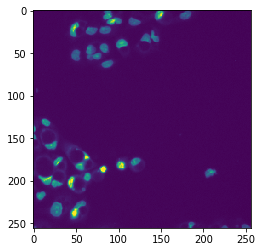

In [134]:
plt.imshow(target_image.astype(np.float).mean(-1))

In [135]:
path

'../data/train/c620631271a56407d6d69fa1a69451ca99c50dcc30e29db04cf6fb7cacbde8cb'

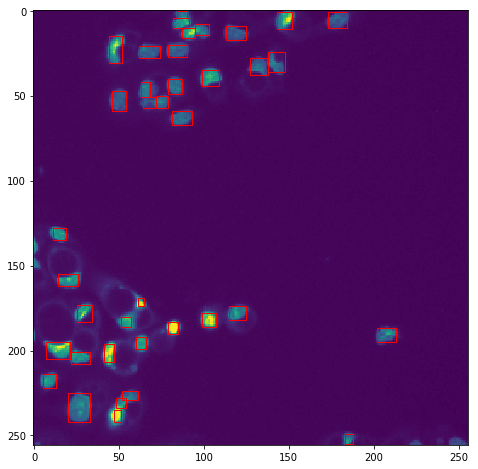

In [136]:
(target_bounding_boxes, target_image, target_scores, _), _ = generator.next()

target_bounding_boxes = np.squeeze(target_bounding_boxes)

target_image = np.squeeze(target_image)

target_scores = np.argmax(target_scores, -1)
target_scores = np.squeeze(target_scores)

_, axis = matplotlib.pyplot.subplots(1, figsize=(12, 8))

axis.imshow(target_image.astype(np.float).mean(-1))

for target_index, target_score in enumerate(target_scores):
    if target_score > 0:
        xy = [
            target_bounding_boxes[target_index][0],
            target_bounding_boxes[target_index][1]
        ]

        w = target_bounding_boxes[target_index][2] - target_bounding_boxes[target_index][0]
        h = target_bounding_boxes[target_index][3] - target_bounding_boxes[target_index][1]

        rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="r", facecolor="none")

        axis.add_patch(rectangle)

matplotlib.pyplot.show()